### Model 6. Seasonal autoregressive integraded moving average model (SARIMA)

SARIMA($p$, $d$, $q$)($P$, $D$, $Q$, $s$) is able to model non-stationary model. It is actually the combination of several component models which are introduced breifly below.

1. Seasonality S($P$, $D$, $Q$, $s$): $s$ is simply the season's length. Definitions of $P$, $Q$ are similar to those of p and q below, but for the seasonal component. $D$ is the order of seasonal integration representing the number of differences required to remove seasonality from the series.

2. Autoregressive model AR($p$): This is basically a regression of the time series onto itself. Here, we assume that the current values depends on its previous values with some lag.

3. Order of Integration I($d$): Parameter $d$ is the number of differences required to make the series stationary.

4. Moving Average MA($q$): Parameter $q$ is the biggest lag after which other lags are not significant on the autocorrelation plot

#### Stationarity

A time series is said to be stationary if its statistical properties (constant mean, variance) do not change over time.

A stationary time series is ideal because it is easier to model. However, stock price is frequently not stationary as we often see a growing/declining trend or its variance is changing under different economic contexts.

In [1]:
import pandas as pd
GOOGL = pd.read_csv('data/GOOGL.csv')

In [2]:
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

In below, we fix the parameters $d, D, s$

In [3]:
#Set initial values and some bounds
ps = range(10, 18)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 3

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

1000

#### Akaike Information Criterion (AIC)
AIC is a method for evaluating how well a model fits the data it was generated from. 
In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.

AIC is calculated from the number of independent variables used to build the model and the maximum likelihood estimate of the model.

The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

In [4]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(GOOGL['4. close'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
#I deleted a few lines here from the original codes so error does not occur when running
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)
print(result_table)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(GOOGL['4. close'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

        parameters          aic
0    (10, 0, 0, 0)  1075.726790
1    (10, 0, 0, 1)  1057.348302
2    (10, 0, 0, 2)  1060.309711
3    (10, 0, 0, 3)  1059.990918
4    (10, 0, 0, 4)  1062.158982
..             ...          ...
130  (17, 2, 0, 1)  1066.604307
131  (17, 2, 0, 3)  1068.744086
132  (17, 2, 0, 4)  1068.887044
133  (17, 3, 0, 0)  1069.474110
134  (17, 4, 0, 0)  1070.615388

[135 rows x 2 columns]
                                     SARIMAX Results                                      
Dep. Variable:                           4. close   No. Observations:                  100
Model:             SARIMAX(10, 1, 0)x(0, 1, 0, 3)   Log Likelihood                -526.863
Date:                            Thu, 21 Apr 2022   AIC                           1075.727
Time:                                    21:20:52   BIC                           1103.935
Sample:                                         0   HQIC                          1087.129
                                            - 

In the following, we calculate the MSE in order to compare SARIMA with other models.

In [6]:
from sklearn.metrics import mean_squared_error
mean_squared_error(
    best_model.predict(start=1, end=100), 
    GOOGL['4. close'][-100:])

20805.603304885473

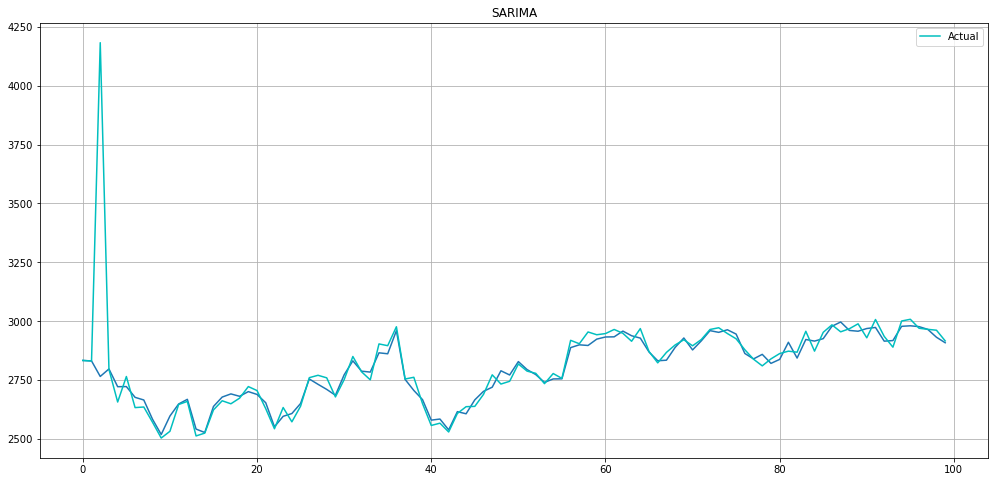

In [7]:
import matplotlib.pyplot as plt
def plot(series_true, series_pred):
    plt.figure(figsize=(17, 8))
    plt.plot(series_true)
    plt.plot(series_pred.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("SARIMA")
    plt.grid(True);
plot(GOOGL['4. close'], best_model.predict(start=1, end=100))